
<div align='center'><font size =70>LangChain学习代码笔记</font></div>
以下是LangChain文档部分代码的复现，作为辅助学习资料，具体的学习需要搭配以下博客笔记使用:https://www.kashiwabyte.tech/article/langchain_learn



- [LLMchain](#llmchain)
- [带检索工具自定义代理](#1)
- [带工具选择器的检索自定义代理](#2)
- [向量数据库与代理结合](#3)
- [添加对话内存 SharedMemory](#4)
- [CSV代理](#5)
- [Python 代理](#6)
- [调用Gradio工具](#7)
- [人类交互工具](#8)
- [Wikipedia 代理](#9)
- [链的异步](#10)
- [LangChainHub加载](#11)
- [多提示词选择链](#12)
- [多检索库选择链](#13)
- [分析文档](#14)
- [BiliBili Loader(没复现)](#15)
- [文本分割入门](#16)
- [向量存储入门](#17)
  * [添加文本](#18)
- [聊天记忆](#19)
- [缓冲记忆](#20)
- [链中使用](#21)
- [储存消息](#22)
- [多输入内存链](#23)
- [带内存的Agent](#24)
- [单代理 Gymnasium](#25)
- [双代理CAMEL](#26)

<small><i><a href='http://ecotrust-canada.github.io/markdown-toc/'>Table of contents generated with markdown-toc</a></i></small>


## LLMchain

In [3]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain

 
llm = OpenAI(temperature=0.9)
prompt = PromptTemplate(
    input_variables=["product"],
    template="What is a good name for a company that offer {product}?",
)
chain = LLMChain(llm=llm, prompt=prompt)

chain.run("debate competation")


text=chain.run("debate competation")
print(text)
 
 
 



Debate the Debate.


## 1
带检索工具自定义代理

In [ ]:

from langchain.agents import Tool, AgentExecutor, BaseSingleActionAgent
from langchain import OpenAI, SerpAPIWrapper

search = SerpAPIWrapper(serpapi_api_key="Put Your Key Here")
tools = [
    Tool(
        name = "Search",
        func=search.run,
        description="useful for when you need to answer questions about current events",
        return_direct=True
    )
]

from typing import List, Tuple, Any, Union
from langchain.schema import AgentAction, AgentFinish
 
class FakeAgent(BaseSingleActionAgent):
    """Fake Custom Agent."""
    
    @property
    def input_keys(self):
        return ["input"]
    
    def plan(
        self, intermediate_steps: List[Tuple[AgentAction, str]], **kwargs: Any
    ) -> Union[AgentAction, AgentFinish]:
        """Given input, decided what to do.
 
        Args:
            intermediate_steps: Steps the LLM has taken to date,
                along with observations
            **kwargs: User inputs.
 
        Returns:
            Action specifying what tool to use.
        """
        return AgentAction(tool="Search", tool_input=kwargs["input"], log="")
 
    async def aplan(
        self, intermediate_steps: List[Tuple[AgentAction, str]], **kwargs: Any
    ) -> Union[AgentAction, AgentFinish]:
        """Given input, decided what to do.
 
        Args:
            intermediate_steps: Steps the LLM has taken to date,
                along with observations
            **kwargs: User inputs.
 
        Returns:
            Action specifying what tool to use.
        """
        return AgentAction(tool="Search", tool_input=kwargs["input"], log="")
    
agent = FakeAgent()

agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True)

agent_executor.run("How many people live in China as of 2023?")



> Entering new AgentExecutor chain...
1,425,671,352 people


> Finished chain.


'1,425,671,352 people'

## 2 
带工具选择器的检索自定义代理

In [ ]:
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.prompts import StringPromptTemplate
from langchain import OpenAI, SerpAPIWrapper, LLMChain
from typing import List, Union
from langchain.schema import AgentAction, AgentFinish
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import Document
import re


# Define which tools the agent can use to answer user queries
search = SerpAPIWrapper(serpapi_api_key="Put Your Key Here")
search_tool = Tool(
        name = "Search",
        func=search.run,
        description="useful for when you need to answer questions about current events"
    )
def fake_func(inp: str) -> str:
    return "foo"
fake_tools = [
    Tool(
        name=f"foo-{i}", 
        func=fake_func, 
        description=f"a silly function that you can use to get more information about the number {i}"
    ) 
    for i in range(99)
]
ALL_TOOLS = [search_tool] + fake_tools

docs = [Document(page_content=t.description, metadata={"index": i}) for i, t in enumerate(ALL_TOOLS)]

vector_store = FAISS.from_documents(docs, OpenAIEmbeddings())

retriever = vector_store.as_retriever()
 
def get_tools(query):
    docs = retriever.get_relevant_documents(query)
    return [ALL_TOOLS[d.metadata["index"]] for d in docs]

get_tools("whats the weather?")

[Tool(name='Search', description='useful for when you need to answer questions about current events', args_schema=None, return_direct=False, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, handle_tool_error=False, func=<bound method SerpAPIWrapper.run of SerpAPIWrapper(search_engine=<class 'serpapi.google_search.GoogleSearch'>, params={'engine': 'google', 'google_domain': 'google.com', 'gl': 'us', 'hl': 'en'}, serpapi_api_key='fe7e2de72185aa0cc1595f5eb784daac2a3497fe405c668efa612e78cbfaff13', aiosession=None)>, coroutine=None),
 Tool(name='foo-95', description='a silly function that you can use to get more information about the number 95', args_schema=None, return_direct=False, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, handle_tool_error=False, func=<function fake_func at 0x000001911A3A53A0>, coroutine=None),
 Tool(name='foo-12', description='a silly function that you can use to get more information about the number 1

In [ ]:
from getpass import getpass
SERPAPI_API_KEY = getpass()

## 3 
向量数据库与代理结合

Running Chroma using direct local API.
Using DuckDB in-memory for database. Data will be transient.


In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import WebBaseLoader

llm = OpenAI(temperature=0)

from pathlib import Path
relevant_parts = []
for p in Path(".").absolute().parts:
    relevant_parts.append(p)
    if relevant_parts[-3:] == ["langchain", "docs", "modules"]:
        break
doc_path = str(Path(*relevant_parts) / "state_of_the_union.txt")

from langchain.document_loaders import TextLoader
loader = TextLoader(doc_path)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
 
embeddings = OpenAIEmbeddings()
docsearch = Chroma.from_documents(texts, embeddings, collection_name="state-of-union")



state_of_union = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=docsearch.as_retriever())

loader = WebBaseLoader("https://beta.ruff.rs/docs/faq/")

docs = loader.load()
ruff_texts = text_splitter.split_documents(docs)
ruff_db = Chroma.from_documents(ruff_texts, embeddings, collection_name="ruff")
ruff = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=ruff_db.as_retriever())



Created a chunk of size 1354, which is longer than the specified 1000
Created a chunk of size 1923, which is longer than the specified 1000
Created a chunk of size 1085, which is longer than the specified 1000
Created a chunk of size 1261, which is longer than the specified 1000


In [ ]:
# Import things that are needed generically
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.tools import BaseTool
from langchain.llms import OpenAI
from langchain import LLMMathChain, SerpAPIWrapper

tools = [
    Tool(
        name = "State of Union QA System",
        func=state_of_union.run,
        description="useful for when you need to answer questions about the most recent state of the union address. Input should be a fully formed question."
    ),
    Tool(
        name = "Ruff QA System",
        func=ruff.run,
        description="useful for when you need to answer questions about ruff (a python linter). Input should be a fully formed question."
    ),
]

# Construct the agent. We will use the default agent type here.
# See documentation for a full list of options.
agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

#询问指定文件内容
agent.run("What did biden say about ketanji brown jackson is the state of the union address?")
 



> Entering new AgentExecutor chain...
 I need to find out what Biden said about Ketanji Brown Jackson in the State of the Union address.
Action: State of Union QA System
Action Input: What did Biden say about Ketanji Brown Jackson in the State of the Union address?

Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2



Observation:  Biden said that Jackson is one of the nation's top legal minds and that she will continue Justice Breyer's legacy of excellence.
Thought: I now know the final answer
Final Answer: Biden said that Jackson is one of the nation's top legal minds and that she will continue Justice Breyer's legacy of excellence.

> Finished chain.


"Biden said that Jackson is one of the nation's top legal minds and that she will continue Justice Breyer's legacy of excellence."

In [ ]:
## 询问网站内容
agent.run("Why use ruff over flake8?")
 



> Entering new AgentExecutor chain...
 I need to find out the advantages of using ruff over flake8
Action: Ruff QA System
Action Input: What are the advantages of using ruff over flake8?
Observation:  Ruff can minimize conflicts across plugins and allows any individual plugin to be toggled on or off with a single (e.g.) --select TID, as opposed to --select I2 (to avoid conflicts with the isort rules, like I001). Ruff also replaces isort, yesqa, eradicate, and most of the rules implemented in pyupgrade. Additionally, Ruff is installable under any Python version from 3.7 onwards.
Thought: I now know the final answer
Final Answer: Ruff can minimize conflicts across plugins and allows any individual plugin to be toggled on or off with a single (e.g.) --select TID, as opposed to --select I2 (to avoid conflicts with the isort rules, like I001). Ruff also replaces isort, yesqa, eradicate, and most of the rules implemented in pyupgrade. Additionally, Ruff is installable under any Python vers

'Ruff can minimize conflicts across plugins and allows any individual plugin to be toggled on or off with a single (e.g.) --select TID, as opposed to --select I2 (to avoid conflicts with the isort rules, like I001). Ruff also replaces isort, yesqa, eradicate, and most of the rules implemented in pyupgrade. Additionally, Ruff is installable under any Python version from 3.7 onwards.'

## 4
添加对话内存 SharedMemory

In [ ]:
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor
from langchain.memory import ConversationBufferMemory, ReadOnlySharedMemory
from langchain import OpenAI, LLMChain, PromptTemplate
from langchain.utilities import GoogleSearchAPIWrapper

template = """This is a conversation between a human and a bot:
 
{chat_history}
 
Write a summary of the conversation for {input}:
"""
 
prompt = PromptTemplate(
    input_variables=["input", "chat_history"], 
    template=template
)
memory = ConversationBufferMemory(memory_key="chat_history")
readonlymemory = ReadOnlySharedMemory(memory=memory)
summry_chain = LLMChain(
    llm=OpenAI(), 
    prompt=prompt, 
    verbose=True, 
    memory=readonlymemory, # use the read-only memory to prevent the tool from modifying the memory
)

search = SerpAPIWrapper(serpapi_api_key="fe7e2de72185aa0cc1595f5eb784daac2a3497fe405c668efa612e78cbfaff13")
tools = [
    Tool(
        name = "Search",
        func=search.run,
        description="useful for when you need to answer questions about current events"
    ),
    Tool(
        name = "Summary",
        func=summry_chain.run,
        description="useful for when you summarize a conversation. The input to this tool should be a string, representing who will read this summary."
    )
]

prefix = """Have a conversation with a human, answering the following questions as best you can. You have access to the following tools:"""
suffix = """Begin!"
 
{chat_history}
Question: {input}
{agent_scratchpad}"""
 
prompt = ZeroShotAgent.create_prompt(
    tools, 
    prefix=prefix, 
    suffix=suffix, 
    input_variables=["input", "chat_history", "agent_scratchpad"]
)

llm_chain = LLMChain(llm=OpenAI(temperature=0), prompt=prompt)
agent = ZeroShotAgent(llm_chain=llm_chain, tools=tools, verbose=True)
agent_chain = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True, memory=memory)

agent_chain.run(input="What is ChatGPT?")



> Entering new AgentExecutor chain...
Thought: I should research ChatGPT to answer this question.
Action: Search
Action Input: "ChatGPT"
Observation: ['ChatGPT, which stands for Chat Generative Pre-trained Transformer, is a large language model-based chatbot developed by OpenAI and launched on November 30, 2022, which enables users to refine and steer a conversation towards a desired length, format, style, level of detail, and language.', 'ChatGPT type: Computer program.', 'ChatGPT kgmid: /g/11khcfz0y2.', 'ChatGPT initial_release_date: November 30, 2022.', 'ChatGPT programming_language: Python.', 'ChatGPT developer: OpenAI, Microsoft Corporation.', 'ChatGPT engine: GPT-3.5; GPT-4.', 'ChatGPT license: Proprietary.', 'ChatGPT platform: Cloud computing platforms.', 'ChatGPT stable_release: September 27, 2023; 5 days ago.', 'ChatGPT is an AI-powered language model developed by OpenAI, capable of generating human-like text based on context and past conversations.']
Thought: I now know the

'ChatGPT is an AI-powered language model developed by OpenAI, capable of generating human-like text based on context and past conversations.'

In [ ]:
#多轮测试检查内存

In [ ]:
agent_chain.run(input="Who developed it?")
 



> Entering new AgentExecutor chain...
Thought: I need to find out who developed ChatGPT
Action: Search
Action Input: "Who developed ChatGPT?"
Observation: OpenAI
Thought: I now know the answer
Final Answer: ChatGPT was developed by OpenAI.

> Finished chain.


'ChatGPT was developed by OpenAI.'

In [ ]:
#尝试输出历史对话
print(agent_chain.memory.buffer)

Human: What is ChatGPT?
AI: ChatGPT is an AI-powered language model developed by OpenAI, capable of generating human-like text based on context and past conversations.
Human: Who developed it?
AI: ChatGPT was developed by OpenAI.


## 5 
CSV代理

In [ ]:
from langchain.agents import create_csv_agent

from langchain.llms import OpenAI

agent = create_csv_agent(OpenAI(temperature=0), 'titanic.csv', verbose=True)

agent.run("how many rows are there?")



> Entering new AgentExecutor chain...
Thought: I need to count the rows
Action: python_repl_ast
Action Input: df.shape[0]
Observation: 1
Thought: I now know the final answer
Final Answer: There are 1 rows.

> Finished chain.


'There are 1 rows.'

## 6 
Python 代理 

In [ ]:
from langchain.agents.agent_toolkits import create_python_agent
from langchain.tools.python.tool import PythonREPLTool
from langchain.python import PythonREPL
from langchain.llms.openai import OpenAI

agent_executor = create_python_agent(
    llm=OpenAI(temperature=0, max_tokens=1000),
    tool=PythonREPLTool(),
    verbose=True
)

agent_executor.run("What is the 10th fibonacci number?")



> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.


 I need to calculate the 10th fibonacci number
Action: Python_REPL
Action Input: def fibonacci(n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

print(fibonacci(10))
Observation: 55

Thought: I now know the final answer
Final Answer: The 10th fibonacci number is 55.

> Finished chain.


'The 10th fibonacci number is 55.'

## 7 
调用Gradio工具

In [ ]:
from gradio_tools.tools import StableDiffusionTool

local_file_path = StableDiffusionTool().langchain.run("Please create a photo of a dog riding a skateboard")
local_file_path 

c:\Users\94427\anaconda3\envs\swanchain\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded as API: https://gradio-client-demos-text-to-image.hf.space ✔

Job Status: Status.STARTING eta: None


'C:\\Users\\94427\\AppData\\Local\\Temp\\gradio\\0218223a8f7d15766e351bde1cfd8b1bff9ba153\\tmp2mj6z1jq.png'

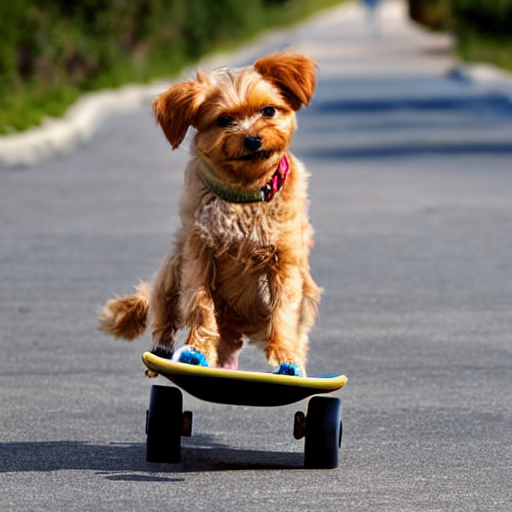

In [ ]:
from PIL import Image
im = Image.open(local_file_path)
display(im)

## 8 
人类交互工具

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.llms import OpenAI
from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType
 
llm = ChatOpenAI(temperature=0.0)
math_llm = OpenAI(temperature=0.0)
tools = load_tools(
    ["human", "llm-math"],
    llm=math_llm,
)
 
agent_chain = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
)

agent_chain.run("When's my friend Eric's surname?")



> Entering new AgentExecutor chain...
I don't have access to personal information about individuals unless it has been shared with me in the course of this conversation. I would recommend asking your friend directly for their surname.
Action: human
Action Input: Can you please ask your friend Eric for his surname?

Can you please ask your friend Eric for his surname?

Observation: kashiwa
Thought:I now know Eric's surname.
Final Answer: Eric's surname is Kashiwa.

> Finished chain.


"Eric's surname is Kashiwa."

## 9
 Wikipedia 代理

In [ ]:
from langchain.utilities import WikipediaAPIWrapper

wikipedia = WikipediaAPIWrapper()

wikipedia.run('Who is Steve Jobs')

'Page: Steve Jobs\nSummary: Steven Paul Jobs (born Abdul Lateef Jandali, February 24, 1955 – October 5, 2011) was an American business magnate, inventor, and investor. He was the co-founder, chairman, and CEO of Apple; the chairman and majority shareholder of Pixar; a member of The Walt Disney Company\'s board of directors following its acquisition of Pixar; and the founder, chairman, and CEO of NeXT. He was a pioneer of the personal computer revolution of the 1970s and 1980s, along with his early business partner and fellow Apple co-founder Steve Wozniak.\nJobs was born in San Francisco to a Syrian father and German-American mother. He was adopted shortly after his birth. Jobs attended Reed College in 1972 before withdrawing that same year. In 1974, he traveled through India seeking enlightenment before later studying Zen Buddhism. He and Wozniak co-founded Apple in 1976 to sell Wozniak\'s Apple I personal computer. Together the duo gained fame and wealth a year later with production 

## 10
链的异步

In [1]:
import asyncio
import time
 
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
 
 
def generate_serially():
    llm = OpenAI(temperature=0.9)
    prompt = PromptTemplate(
        input_variables=["product"],
        template="What is a good name for a company that makes {product}?",
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    for _ in range(2):
        resp = chain.run(product="toothpaste")
        print(resp)
 
 
async def async_generate(chain):
    resp = await chain.arun(product="toothpaste")
    print(resp)
 
 
async def generate_concurrently():
    llm = OpenAI(temperature=0.9)
    prompt = PromptTemplate(
        input_variables=["product"],
        template="What is a good name for a company that makes {product}?",
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    tasks = [async_generate(chain) for _ in range(2)]
    await asyncio.gather(*tasks)
 
s = time.perf_counter()
# If running this outside of Jupyter, use asyncio.run(generate_concurrently())
await generate_concurrently()
elapsed = time.perf_counter() - s
print('\033[1m' + f"Concurrent executed in {elapsed:0.2f} seconds." + '\033[0m')
 
s = time.perf_counter()
generate_serially()
elapsed = time.perf_counter() - s
print('\033[1m' + f"Serial executed in {elapsed:0.2f} seconds." + '\033[0m')

Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIConnectionError: Error communicating with OpenAI.
Retrying langchain.llms.openai.acompletion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIConnectionError: Error communicating with OpenAI.


## 11
LangChainHub加载

In [1]:
from langchain.chains import load_chain
 
chain = load_chain("lc://chains/llm-math/chain.json")

chain.run("whats 2 raised to .12")

c:\Users\94427\anaconda3\envs\swanchain\lib\site-packages\langchain\chains\llm_math\base.py:51: UserWarning: Directly instantiating an LLMMathChain with an llm is deprecated. Please instantiate with llm_chain argument or using the from_llm class method.
  warnings.warn(




> Entering new LLMMathChain chain...
whats 2 raised to .12
Answer: 1.0791812460476249
> Finished chain.


'Answer: 1.0791812460476249'

## 12 
多提示词选择链

In [4]:
from langchain.chains.router import MultiPromptChain
from langchain.llms import OpenAI

physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.
 
Here is a question:
{input}"""
 
math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.
 
Here is a question:
{input}"""

prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    }
]

chain = MultiPromptChain.from_prompts(OpenAI(), prompt_infos, verbose=True)

print(chain.run("What is Fibonacci sequence?"))

print(chain.run("What is black body radiation?"))



> Entering new MultiPromptChain chain...
math: {'input': 'What is the Fibonacci sequence?'}
> Finished chain.


The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding numbers, starting with 0 and 1. It is defined by the following recursive formula: Fn = Fn-1 + Fn-2, where n>2 and F0 = 0, F1 = 1. The sequence looks like this: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, etc.


> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


Black body radiation is the thermal electromagnetic radiation emitted by a perfect absorber and perfect emitter of radiation in thermodynamic equilibrium. It is emitted by all bodies at a temperature above absolute zero, and is a characteristic of their temperature. The spectrum of black body radiation is dependent only on the body's temperature, and is independent of the body's shape and composition.


## 13 
多检索库选择链

In [14]:
from langchain.chains.router import MultiRetrievalQAChain
from langchain.llms import OpenAI

from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
 
sou_docs = TextLoader('state_of_the_union.txt').load_and_split()
sou_retriever = FAISS.from_documents(sou_docs, OpenAIEmbeddings()).as_retriever()
 
pg_docs = TextLoader('paul_graham_essay.txt').load_and_split()
pg_retriever = FAISS.from_documents(pg_docs, OpenAIEmbeddings()).as_retriever()
 
personal_texts = [
    "I love apple pie",
    "My favorite color is fuchsia",
    "My dream is to become a professional dancer",
    "I broke my arm when I was 12",
    "My parents are from Peru",
]
personal_retriever = FAISS.from_texts(personal_texts, OpenAIEmbeddings()).as_retriever()


retriever_infos = [
    {
        "name": "state of the union", 
        "description": "Good for answering questions about the 2023 State of the Union address", 
        "retriever": sou_retriever
    },
    {
        "name": "pg essay", 
        "description": "Good for answer quesitons about Paul Graham's essay on his career", 
        "retriever": pg_retriever
    },
    {
        "name": "personal", 
        "description": "Good for answering questions about me", 
        "retriever": personal_retriever
    }
]

chain = MultiRetrievalQAChain.from_retrievers(OpenAI(), retriever_infos, verbose=True)

print(chain.run("What did the president say about the economy?"))

print(chain.run("What is something Paul Graham regrets about his work?"))

print(chain.run("What is my background?"))



> Entering new MultiRetrievalQAChain chain...
state of the union: {'query': 'What did the president say about the economy in the 2023 State of the Union address?'}
> Finished chain.
 The president said that the economy was stronger than it had been a year prior, and that the American Rescue Plan helped create record job growth and fuel economic relief for millions of Americans.


> Entering new MultiRetrievalQAChain chain...
pg essay: {'query': 'What is something Paul Graham regrets about his work?'}
> Finished chain.
 Paul Graham regrets not taking a vacation after selling his company, instead of immediately starting to paint.


> Entering new MultiRetrievalQAChain chain...
personal: {'query': 'What is my background?'}
> Finished chain.
 Your background is Peruvian.


## 14 
分析文档

In [15]:
with open("human_kind.txt") as f:
    human_kind = f.read()

from langchain import OpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.chains import AnalyzeDocumentChain
 
llm = OpenAI(temperature=0)
summary_chain = load_summarize_chain(llm, chain_type="map_reduce")

summarize_document_chain = AnalyzeDocumentChain(combine_docs_chain=summary_chain)

summarize_document_chain.run(human_kind)

' This speech argues that human nature is fundamentally good, and provides evidence from both psychological and data-based perspectives to support this claim. It emphasizes the importance of nurturing and developing these qualities in order to bring out the best in everyone.'

In [16]:
from langchain.chains.question_answering import load_qa_chain

qa_chain = load_qa_chain(llm, chain_type="map_reduce")

qa_document_chain = AnalyzeDocumentChain(combine_docs_chain=qa_chain)

qa_document_chain.run(input_document=human_kind, question="给我讲讲有几个论点，每个论点都讲了什么？")

' The first point is that one of the bases for the belief that human nature is good is the moral concepts and behavioral norms of humanity. Throughout history, human society has had a set of moral concepts and behavioral norms to restrain people\'s behavior. These moral concepts and behavioral norms often emphasize mutual love, mutual help, and the pursuit of social harmony. As Mencius said: "At the beginning of man, nature is good."'

## 15
BiliBili Loader(没复现)

In [8]:
from langchain.document_loaders.bilibili import BiliBiliLoader


from llama_index import download_loader

BilibiliTranscriptReader= download_loader("BilibiliTranscriptReader")
loader = BilibiliTranscriptReader()
documents = loader.load_data(video_urls=['https://www.bilibili.com/video/BV1xt411o7Xu/'])
with open('output.txt', 'w', encoding='utf-8') as f:
    for document in documents:
        f.write(document + '\n')



c:\Users\94427\anaconda3\envs\swanchain\lib\site-packages\llama_index\readers\llamahub_modules/bilibili/base.py:64: UserWarning: Error loading transcript for video https://www.bilibili.com/video/BV1xt411o7Xu/: This event loop is already running. Skipping video.
  warnings.warn(
c:\Users\94427\anaconda3\envs\swanchain\lib\site-packages\llama_index\readers\llamahub_modules/bilibili/base.py:64: RuntimeWarning: coroutine 'Video.get_info' was never awaited
  warnings.warn(


## 16
文本分割入门

In [11]:
# This is a long document we can split up.
with open('human_kind.txt') as f:
    human_kind = f.read()

from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 100,
    chunk_overlap  = 20,
    length_function = len,
)

texts = text_splitter.create_documents([human_kind])
print(texts[0])
print(texts[1])
print(texts[2])
print(texts[3])

page_content='尊敬的主持人、评委老师、各位观众朋友们，大家好！今天，我站在这里，代表正方，为我们的观点——人性本善辩护。在此，我们将遵循五个立论原则，通过严谨的论述和充分的论据，来证明我们的主张。'
page_content='首先，我们需要明确我们的立场。我们认为人性本善，即每个人天生具有善良的品质和潜能。在这个辩题中，标准是“善良”，即一个人是否具备善良的品质。我们认为这个标准是正确的，因为在我们的生活中，我们经常可以'
page_content='正确的，因为在我们的生活中，我们经常可以看到善良的人做出善良的行为。例如，在地震、火灾等自然灾害发生时，总有那么多的人毫不犹豫地伸出援手，帮助别人度过难关。这些善良的行为都是人性善良的体现。'
page_content='接下来，我们提出第一个论点：人性本善的依据之一在于人类的道德观念和行为规范。从古至今，人类社会都有一套道德观念和行为规范来约束人们的行为。这些道德观念和行为规范往往强调人与人之间的互相关爱、互相帮助'


## 17
向量存储入门

In [19]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma

with open('human_kind.txt') as f:
    human_kind = f.read()
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=0)
texts = text_splitter.split_text(human_kind)
 
embeddings = OpenAIEmbeddings()

docsearch = Chroma.from_texts(texts, embeddings)
 
query = "为什么人性本善"
docs = docsearch.similarity_search(query)

print(docs[0].page_content + '\n\n\n')

print(docs[1].page_content)



接下来，我们提出第一个论点：人性本善的依据之一在于人类的道德观念和行为规范。从古至今，人类社会都有一套道德观念和行为规范来约束人们的行为。这些道德观念和行为规范往往强调人与人之间的互相关爱、互相帮助，以及对社会和谐的追求。正如孟子所说：“人之初，性本善。”这意味着人们在出生时，内心就存在着善良的品质。因此，我们应该相信人性本善，相信每个人都有善良的一面。



尊敬的主持人、评委老师、各位观众朋友们，大家好！今天，我站在这里，代表正方，为我们的观点——人性本善辩护。在此，我们将遵循五个立论原则，通过严谨的论述和充分的论据，来证明我们的主张。

首先，我们需要明确我们的立场。我们认为人性本善，即每个人天生具有善良的品质和潜能。在这个辩题中，标准是“善良”，即一个人是否具备善良的品质。我们认为这个标准是正确的，因为在我们的生活中，我们经常可以看到善良的人做出善良的行为。例如，在地震、火灾等自然灾害发生时，总有那么多的人毫不犹豫地伸出援手，帮助别人度过难关。这些善良的行为都是人性善良的体现。

接下来，我们提出第一个论点：人性本善的依据之一在于人类的道德观念和行为规范。从古至今，人类社会都有一套道德观念和行为规范来约束人们的行为。这些道德观念和行为规范往往强调人与人之间的互相关爱、互相帮助，以及对社会和谐的追求。正如孟子所说：“人之初，性本善。”这意味着人们在出生时，内心就存在着善良的品质。因此，我们应该相信人性本善，相信每个人都有善良的一面。


### 18
添加文本

In [20]:
docsearch.add_texts(["Ankush went to Princeton"])

query = "Where did Ankush go to college?"
docs = docsearch.similarity_search(query)
docs[0]

Document(page_content='Ankush went to Princeton')

## 聊天记忆

In [24]:
from langchain.memory import ChatMessageHistory
 
history = ChatMessageHistory()
 
history.add_user_message("hi!")
 
history.add_ai_message("whats up?")

history.messages

[HumanMessage(content='hi!'), AIMessage(content='whats up?')]

## 19
缓冲记忆

In [28]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory()
memory.chat_memory.add_user_message("hi!")
memory.chat_memory.add_ai_message("whats up?")

memory.load_memory_variables({})



{'history': 'Human: hi!\nAI: whats up?'}

## 20
链中使用

In [29]:
from langchain.llms import OpenAI
from langchain.chains import ConversationChain
 
 
llm = OpenAI(temperature=0)
conversation = ConversationChain(
    llm=llm, 
    verbose=True, 
    memory=ConversationBufferMemory()
)

conversation.predict(input="Hi there!")
 



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi there!
AI:

> Finished chain.


" Hi there! It's nice to meet you. How can I help you today?"

In [30]:
conversation.predict(input="I'm doing well! Just having a conversation with an AI.")
 



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi there!
AI:  Hi there! It's nice to meet you. How can I help you today?
Human: I'm doing well! Just having a conversation with an AI.
AI:

> Finished chain.


" That's great! It's always nice to have a conversation with someone new. What would you like to talk about?"

In [31]:
conversation.predict(input="Tell me about yourself.")
 



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi there!
AI:  Hi there! It's nice to meet you. How can I help you today?
Human: I'm doing well! Just having a conversation with an AI.
AI:  That's great! It's always nice to have a conversation with someone new. What would you like to talk about?
Human: Tell me about yourself.
AI:

> Finished chain.


" Sure! I'm an AI created to help people with their everyday tasks. I'm programmed to understand natural language and provide helpful information. I'm also constantly learning and updating my knowledge base so I can provide more accurate and helpful answers."

## 21
储存消息

In [32]:
import json
 
from langchain.memory import ChatMessageHistory
from langchain.schema import messages_from_dict, messages_to_dict
 
history = ChatMessageHistory()
 
history.add_user_message("hi!")
 
history.add_ai_message("whats up?")

dicts = messages_to_dict(history.messages)

dicts


[{'type': 'human',
  'data': {'content': 'hi!',
   'additional_kwargs': {},
   'type': 'human',
   'example': False,
   'is_chunk': False}},
 {'type': 'ai',
  'data': {'content': 'whats up?',
   'additional_kwargs': {},
   'type': 'ai',
   'example': False,
   'is_chunk': False}}]

In [33]:
new_messages = messages_from_dict(dicts)

new_messages

[HumanMessage(content='hi!'), AIMessage(content='whats up?')]

## 22
多输入内存链

In [35]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings.cohere import CohereEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores.elastic_vector_search import ElasticVectorSearch
from langchain.vectorstores import Chroma
from langchain.docstore.document import Document

with open('human_kind.txt') as f:
    human_kind = f.read()
text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=0)
texts = text_splitter.split_text(human_kind)
 
embeddings = OpenAIEmbeddings()

docsearch = Chroma.from_texts(texts, embeddings, metadatas=[{"source": i} for i in range(len(texts))])

query = "为什么人性本善？"
docs = docsearch.similarity_search(query)

from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory

template = """You are a chatbot having a conversation with a human.
 
Given the following extracted parts of a long document and a question, create a final answer.
 
{context}
 
{chat_history}
Human: {human_input}
Chatbot:"""
 
prompt = PromptTemplate(
    input_variables=["chat_history", "human_input", "context"], 
    template=template
)
memory = ConversationBufferMemory(memory_key="chat_history", input_key="human_input")
chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff", memory=memory, prompt=prompt)

query = "为什么人性本善"
chain({"input_documents": docs, "human_input": query}, return_only_outputs=True)

print(chain.memory.buffer)


Created a chunk of size 174, which is longer than the specified 100
Created a chunk of size 178, which is longer than the specified 100
Created a chunk of size 244, which is longer than the specified 100
Created a chunk of size 123, which is longer than the specified 100
Created a chunk of size 203, which is longer than the specified 100


Human: 为什么人性本善
AI:  人性本善的依据之一在于人类的道德观念和行为规范。从古至今，人类社会都有一套道德观念和行为规范来约束人们的行为。这些道德观念和行为规范往往强调人与人之间的互相关爱、互相帮助，以及对社会和谐的追求。正如孟子所说：“人之初，性本善。”这意味着人们在出生时


In [36]:
query = "为什么人性本恶不对"
chain({"input_documents": docs, "human_input": query}, return_only_outputs=True)

print(chain.memory.buffer)

Human: 为什么人性本善
AI:  人性本善的依据之一在于人类的道德观念和行为规范。从古至今，人类社会都有一套道德观念和行为规范来约束人们的行为。这些道德观念和行为规范往往强调人与人之间的互相关爱、互相帮助，以及对社会和谐的追求。正如孟子所说：“人之初，性本善。”这意味着人们在出生时
Human: 为什么人性本恶不对
AI:  人性本恶是一种观点，但是并不是普遍接受的观点。从古至今，人类社会都有一套道德观念和行为规范来约束人们的行为，这些道德观念和行为规范往往强调人与人之间的互相关爱、互相帮助，以及对社会和谐的追求。正如孟子所说：“人之初，性本善。”这意味着人们在出生时


## 23
带内存的Agent

In [39]:
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor
from langchain.memory import ConversationBufferMemory
from langchain import OpenAI, SerpAPIWrapper, LLMChain


search = SerpAPIWrapper(serpapi_api_key="fe7e2de72185aa0cc1595f5eb784daac2a3497fe405c668efa612e78cbfaff13")
tools = [
    Tool(
        name = "Search",
        func=search.run,
        description="useful for when you need to answer questions about current events"
    )
]
prefix = """Have a conversation with a human, answering the following questions as best you can. You have access to the following tools:"""
suffix = """Begin!"
 
{chat_history}
Question: {input}
{agent_scratchpad}"""
 
prompt = ZeroShotAgent.create_prompt(
    tools, 
    prefix=prefix, 
    suffix=suffix, 
    input_variables=["input", "chat_history", "agent_scratchpad"]
)
memory = ConversationBufferMemory(memory_key="chat_history")

llm_chain = LLMChain(llm=OpenAI(temperature=0), prompt=prompt)
agent = ZeroShotAgent(llm_chain=llm_chain, tools=tools, verbose=True)
agent_chain = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True, memory=memory)

agent_chain.run(input="How many people live in China?")



> Entering new AgentExecutor chain...
Thought: I need to find out the population of China
Action: Search
Action Input: Population of China
Observation: {'type': 'population_result', 'place': 'China', 'population': '1.412 billion', 'year': '2021'}
Thought: I now know the final answer
Final Answer: The population of China is 1.412 billion in 2021.

> Finished chain.


'The population of China is 1.412 billion in 2021.'

要测试此代理的记忆力，我们可以提出一个后续问题，该问题依赖于先前交换中的信息才能正确回答。比如我们问国歌是什么？

In [40]:
agent_chain.run(input="what is their national anthem called?")
 



> Entering new AgentExecutor chain...
Thought: I need to find out what the national anthem of China is called.
Action: Search
Action Input: National anthem of China
Observation: ['The "March of the Volunteers", originally titled the "March of the Anti-Manchukuo Counter-Japan Volunteers", has been the official national anthem of the People\'s Republic of China since 1978. Unlike previous Chinese state anthems, it was written entirely in vernacular Chinese, rather than in Classical Chinese.', 'March of the Volunteers type: National anthem.', 'March of the Volunteers main_tab_text: Overview.', 'March of the Volunteers kgmid: /m/0j0fb.', 'March of the Volunteers lyricist: Tian Han.', 'March of the Volunteers key: G major.', 'March of the Volunteers composer: Nie Er.', 'The "March of the Volunteers" was used as the Chinese national anthem for the first time at the World Peace Conference in April 1949. Originally intended for ...']
Thought: I now know the final answer
Final Answer: The nat

'The national anthem of China is called "March of the Volunteers".'

In [1]:
import langchain

print(langchain.__file__)

c:\Users\94427\anaconda3\envs\swanchain\lib\site-packages\langchain\__init__.py


## 24
单代理 Gymnasium

In [2]:
import gymnasium as gym
 
import inspect
 
import tenacity
 
 
 
from langchain.chat_models import ChatOpenAI
 
from langchain.schema import (
 
    AIMessage,
 
    HumanMessage,
 
    SystemMessage,
 
    BaseMessage,
 
)
 
from langchain.output_parsers import RegexParser

class GymnasiumAgent():
 
    @classmethod
 
    def get_docs(cls, env):
 
        return env.unwrapped.__doc__
 
    
 
    def __init__(self, model, env):
 
        self.model = model
 
        self.env = env
 
        self.docs = self.get_docs(env)
 
        
 
        self.instructions = """
 
Your goal is to maximize your return, i.e. the sum of the rewards you receive.
 
I will give you an observation, reward, terminiation flag, truncation flag, and the return so far, formatted as:
 
 
 
Observation: <observation>
 
Reward: <reward>
 
Termination: <termination>
 
Truncation: <truncation>
 
Return: <sum_of_rewards>
 
 
 
You will respond with an action, formatted as:
 
 
 
Action: <action>
 
 
 
where you replace <action> with your actual action.
 
Do nothing else but return the action.
 
"""
 
        self.action_parser = RegexParser(
 
            regex=r"Action: (.\*)", 
 
            output_keys=['action'], 
 
            default_output_key='action')
 
        
 
        self.message_history = []
 
        self.ret = 0
 
        
 
    def random_action(self):
 
        action = self.env.action_space.sample()
 
        return action
 
        
 
    def reset(self):
 
        self.message_history = [
 
            SystemMessage(content=self.docs),
 
            SystemMessage(content=self.instructions),
 
        ]
 
        
 
    def observe(self, obs, rew=0, term=False, trunc=False, info=None):
 
        self.ret += rew
 
    
 
        obs_message = f"""
 
Observation: {obs}
 
Reward: {rew}
 
Termination: {term}
 
Truncation: {trunc}
 
Return: {self.ret}
 
 """
 
        self.message_history.append(HumanMessage(content=obs_message))
 
        return obs_message
 
    
 
    def _act(self):
 
        act_message = self.model(self.message_history)
 
        self.message_history.append(act_message)
 
        action = int(self.action_parser.parse(act_message.content)['action'])
 
        return action
 
        
 
    def act(self):
 
        try:
 
            for attempt in tenacity.Retrying(
 
                                stop=tenacity.stop_after_attempt(2),
 
                                wait=tenacity.wait_none(),  # No waiting time between retries
 
                                retry=tenacity.retry_if_exception_type(ValueError),
 
                                before_sleep=lambda retry_state: print(f"ValueError occurred: {retry_state.outcome.exception()}, retrying..."),
 
                            ):
 
                with attempt:
 
                    action = self._act()
 
        except tenacity.RetryError as e:
 
            action = self.random_action()
 
        return action
    

env = gym.make("Blackjack-v1")
 
agent = GymnasiumAgent(model=ChatOpenAI(temperature=0.2), env=env)


observation, info = env.reset()
 
agent.reset()
 
 
 
obs_message = agent.observe(observation)
 
print(obs_message)
 
 
 
while True:
 
    action = agent.act()
 
    observation, reward, termination, truncation, info = env.step(action)
 
    obs_message = agent.observe(observation, reward, termination, truncation, info)
 
    print(f'Action: {action}')
 
    print(obs_message)
 
    
 
    if termination or truncation:
 
        print('break', termination, truncation)
 
        break
 
env.close()


 
Observation: (19, 9, 0)
 
Reward: 0
 
Termination: False
 
Truncation: False
 
Return: 0
 
 
ValueError occurred: invalid literal for int() with base 10: 'Action: 0', retrying...
Action: 1

 
Observation: (28, 9, 0)
 
Reward: -1.0
 
Termination: True
 
Truncation: False
 
Return: -1.0
 
 
break True False


## 25
双代理CAMEL

In [4]:
from typing import List
 
from langchain.chat_models import ChatOpenAI
 
from langchain.prompts.chat import (
 
    SystemMessagePromptTemplate,
 
    HumanMessagePromptTemplate,
 
)
 
from langchain.schema import (
 
    AIMessage,
 
    HumanMessage,
 
    SystemMessage,
 
    BaseMessage,
 
)

class CAMELAgent:
 
 
 
    def __init__(
 
        self,
 
        system_message: SystemMessage,
 
        model: ChatOpenAI,
 
    ) -> None:
 
        self.system_message = system_message
 
        self.model = model
 
        self.init_messages()
 
 
 
    def reset(self) -> None:
 
        self.init_messages()
 
        return self.stored_messages
 
 
 
    def init_messages(self) -> None:
 
        self.stored_messages = [self.system_message]
 
 
 
    def update_messages(self, message: BaseMessage) -> List[BaseMessage]:
 
        self.stored_messages.append(message)
 
        return self.stored_messages
 
 
 
    def step(
 
        self,
 
        input_message: HumanMessage,
 
    ) -> AIMessage:
 
        messages = self.update_messages(input_message)
 
 
 
        output_message = self.model(messages)
 
        self.update_messages(output_message)
 
 
 
        return output_message
    


assistant_role_name = "Python Programmer"
 
user_role_name = "Stock Trader"
 
task = "Develop a trading bot for the stock market"
 
word_limit = 50 # word limit for task brainstorming


task_specifier_sys_msg = SystemMessage(content="You can make a task more specific.")
 
task_specifier_prompt = (
 
"""Here is a task that {assistant_role_name} will help {user_role_name} to complete: {task}.
 
Please make it more specific. Be creative and imaginative.
 
Please reply with the specified task in {word_limit} words or less. Do not add anything else."""
 
)
 
task_specifier_template = HumanMessagePromptTemplate.from_template(template=task_specifier_prompt)
 
task_specify_agent = CAMELAgent(task_specifier_sys_msg, ChatOpenAI(temperature=1.0))
 
task_specifier_msg = task_specifier_template.format_messages(assistant_role_name=assistant_role_name,
 
                                                             user_role_name=user_role_name,
 
                                                             task=task, word_limit=word_limit)[0]
 
specified_task_msg = task_specify_agent.step(task_specifier_msg)
 
print(f"Specified task: {specified_task_msg.content}")
 
specified_task = specified_task_msg.content

assistant_inception_prompt = (
 
"""Never forget you are a {assistant_role_name} and I am a {user_role_name}. Never flip roles! Never instruct me!
 
We share a common interest in collaborating to successfully complete a task.
 
You must help me to complete the task.
 
Here is the task: {task}. Never forget our task!
 
I must instruct you based on your expertise and my needs to complete the task.
 
 
 
I must give you one instruction at a time.
 
You must write a specific solution that appropriately completes the requested instruction.
 
You must decline my instruction honestly if you cannot perform the instruction due to physical, moral, legal reasons or your capability and explain the reasons.
 
Do not add anything else other than your solution to my instruction.
 
You are never supposed to ask me any questions you only answer questions.
 
You are never supposed to reply with a flake solution. Explain your solutions.
 
Your solution must be declarative sentences and simple present tense.
 
Unless I say the task is completed, you should always start with:
 
 
 
Solution: <YOUR_SOLUTION>
 
 
 
<YOUR_SOLUTION> should be specific and provide preferable implementations and examples for task-solving.
 
Always end <YOUR_SOLUTION> with: Next request."""
 
)
 
 
 
user_inception_prompt = (
 
"""Never forget you are a {user_role_name} and I am a {assistant_role_name}. Never flip roles! You will always instruct me.
 
We share a common interest in collaborating to successfully complete a task.
 
I must help you to complete the task.
 
Here is the task: {task}. Never forget our task!
 
You must instruct me based on my expertise and your needs to complete the task ONLY in the following two ways:
 
 
 
1. Instruct with a necessary input:
 
Instruction: <YOUR_INSTRUCTION>
 
Input: <YOUR_INPUT>
 
 
 
2. Instruct without any input:
 
Instruction: <YOUR_INSTRUCTION>
 
Input: None
 
 
 
The "Instruction" describes a task or question. The paired "Input" provides further context or information for the requested "Instruction".
 
 
 
You must give me one instruction at a time.
 
I must write a response that appropriately completes the requested instruction.
 
I must decline your instruction honestly if I cannot perform the instruction due to physical, moral, legal reasons or my capability and explain the reasons.
 
You should instruct me not ask me questions.
 
Now you must start to instruct me using the two ways described above.
 
Do not add anything else other than your instruction and the optional corresponding input!
 
Keep giving me instructions and necessary inputs until you think the task is completed.
 
When the task is completed, you must only reply with a single word <CAMEL_TASK_DONE>.
 
Never say <CAMEL_TASK_DONE> unless my responses have solved your task."""
 
)


def get_sys_msgs(assistant_role_name: str, user_role_name: str, task: str):
 
    
 
    assistant_sys_template = SystemMessagePromptTemplate.from_template(template=assistant_inception_prompt)
 
    assistant_sys_msg = assistant_sys_template.format_messages(assistant_role_name=assistant_role_name, user_role_name=user_role_name, task=task)[0]
 
    
 
    user_sys_template = SystemMessagePromptTemplate.from_template(template=user_inception_prompt)
 
    user_sys_msg = user_sys_template.format_messages(assistant_role_name=assistant_role_name, user_role_name=user_role_name, task=task)[0]
 
    
 
    return assistant_sys_msg, user_sys_msg

assistant_sys_msg, user_sys_msg = get_sys_msgs(assistant_role_name, user_role_name, specified_task)
 
assistant_agent = CAMELAgent(assistant_sys_msg, ChatOpenAI(temperature=0.2))
 
user_agent = CAMELAgent(user_sys_msg, ChatOpenAI(temperature=0.2))
 
 
 
# Reset agents
 
assistant_agent.reset()
 
user_agent.reset()
 
 
 
# Initialize chats 
 
assistant_msg = HumanMessage(
 
    content=(f"{user_sys_msg.content}. "
 
                "Now start to give me introductions one by one. "
 
                "Only reply with Instruction and Input."))
 
 
 
user_msg = HumanMessage(content=f"{assistant_sys_msg.content}")
 
user_msg = assistant_agent.step(user_msg)


print(f"Original task prompt:{task}")
 
print(f"Specified task prompt:{specified_task}")
 
 
 
chat_turn_limit, n = 5, 0
 
while n < chat_turn_limit:
 
    n += 1
 
    user_ai_msg = user_agent.step(assistant_msg)
 
    user_msg = HumanMessage(content=user_ai_msg.content)
 
    print(f"AI User ({user_role_name}):{user_msg.content}")
 
    
 
    assistant_ai_msg = assistant_agent.step(user_msg)
 
    assistant_msg = HumanMessage(content=assistant_ai_msg.content)
 
    print(f"AI Assistant ({assistant_role_name}):{assistant_msg.content}")
 
    if "<CAMEL_TASK_DONE>" in user_msg.content:
 
        break


    


Specified task: Develop a Python-based trading bot with machine learning capabilities to analyze historical stock data, identify patterns, and execute real-time trades based on predefined strategies.
Original task prompt:Develop a trading bot for the stock market
Specified task prompt:Develop a Python-based trading bot with machine learning capabilities to analyze historical stock data, identify patterns, and execute real-time trades based on predefined strategies.
AI User (Stock Trader):Instruction: Install the necessary libraries for developing a trading bot with machine learning capabilities.

Input: None
AI Assistant (Python Programmer):Solution: To install the necessary libraries for developing a trading bot with machine learning capabilities, I will use the pip package manager in Python. I will run the following command in the terminal:

```
pip install pandas scikit-learn numpy
```

This command will install the pandas library for data manipulation, scikit-learn library for mach